# DQMC Code following Tutorial

In [1]:
import numpy as np
import datetime,os
from scipy import linalg as la
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from itertools import product

np.set_printoptions(precision=6)
#%load_ext line_profiler
#%load_ext memory_profiler
#%load_ext cython
%load_ext autoreload

import sys
sys.path.insert(0,"/home/katherine/Documents/GradWork/Devereaux/Code-DQMC/dqmc-edwnh/util")
import util #Edwin's util file
import data_analysis
from bsofi_real import Get_Full_O_Inv

In [2]:
%autoreload 2

# MODEL: Hubbard (NN & NNN) on 2D square lattice, zero/open B.C., zero spin domain S_z = (nup-ndn)/2 = 0. 
# Assume up and down electrons behave the same way - no spin coupling Zeeman term
# Assume all numbers are real

## Kinetic matrix

In [3]:
def makeKMatrix(Nx,Ny,t=1,tp=0,mu=0):
    '''Generate kinetic matrix for 2D square Nx-by-Ny lattice, zero/open bdy conditions.
    Args:
        t = NN hopping strength
        tp = NNN hopping stength
        mu = Chemical potential
        Nx, Ny = Lattice dimensions
    Returns:
        A shape (N,N) float numpy array, N = Nx*Ny. 
        Matrix created is deliberately not sparse. '''

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with zero B.C.
            neighbors = [((x+1),y),((x-1),y),(x,(y+1)),(x,(y-1) )]
            next_neighbors = [((x+1) ,(y+1) ),((x-1) ,(y+1) ),
                              ((x+1),(y-1)),((x-1),(y-1) )]
            #get total indices of nearest neighbors, only hopping inside allowed
            for pt in neighbors: 
                if 0 <= pt[0] < Nx and 0<= pt[1] < Ny:
                    i = np.append(i,pt[0]+ Nx*pt[1]);
                    j = np.append(j,n)
                    data = np.append(data,(-t))
                else: 
                    continue
            #get total indices of next-nearest neighbors, only hopping inside allowed
            for pt in next_neighbors: 
                if 0 <= pt[0] < Nx and 0<= pt[1] < Ny:
                    i = np.append(i,pt[0]+ Nx*pt[1]);
                    j = np.append(j,n)
                    data = np.append(data,(-tp))
                else:
                    continue
            
            #chemical potential contribes only to diagonal elements
            i = np.append(i,n);
            j = np.append(j,n);
            data = np.append(data,-mu)
    
    #Construction
    kmatrix = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny)).toarray()
    return kmatrix

kinetic matrix with phase output datatype: float64


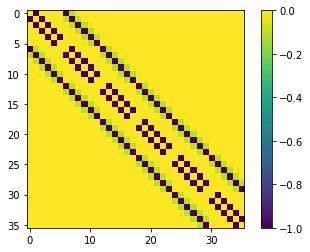

In [4]:
kay = makeKMatrix(6,6,t=1,tp = 0.1,mu=0);
print('kinetic matrix with phase output datatype:',kay.dtype)
plt.imshow(kay);plt.colorbar();

## Exp(V) terms arising from U != 0

In [5]:
def makeExpLamSData(S,spin):
    '''Construct the length N vector exp(spin*lmbd*S[:,l]) for every single l = 0...L-1.
    Each length N vector stands for a diagonal matrix of size N-by-N. 
    There are L total such matrices.
    For efficiency, store information for all L matrices in one N-by-L 2D array.
    Each column represents a different diagonal matrix expV
    
    Args:
        S = (N,L) int np array, current H-S field configuration
        spin = 1 or -1, representing up or down spin
    
    Returns:t
        (N,L) np array storing exp(V(l,spin)) data
    '''
    
    assert spin == 1 or spin == -1, "Spin value must be +1 or -1"
    
    diags = np.zeros((N,L),dtype=float);
    for l in range(L):
        diags[:,l] = np.exp(lmbd*S[:,l]*spin);
        
    return diags

## Equal time Green's function 

In [6]:
def makeGMatrix_QR(expVData,l_shift=0,batch_size=10,check=False):
    '''Calculate equal-time GF from scratch using Pivoted-QR to avoid 
    numerical error accumulation. Method described in tutorial.
    
    Args:
        expVData: N-by-L 2D array, V matrix data (depends on current H-S config).
                  Each column is exp(spin*lmbd*S[:,l]).
        l_shift: Account for change in GF defn after l wraps. 
                 Defaults to 0, no wrapping
        batch_size: Number of B matrices to directly multiply together. 
                    Defaults to 10, a typical safe value
        check: bool, whether to check if batch_size is safe. 
               Defaults to False in simulation
        
    Returns:
        A (N,N) np-array, equal-time GF matrix
        +1 or -1, sign of determinant of this GF matrix
    '''
    
    #dimensions
    N,L = expVData.shape
    
    #account for l_shift wraps: Roll forward, so that we start with 
    # the l-th column in zero-th column
    expVData = np.roll(expVData,-l_shift,axis=1)

    #divide into batches to reduce number of QR decomps we have to do
    num_batches = L//batch_size
    Bmats = [];
    #form every batch by normal matrix multiplication
    for j in range(num_batches):   
        #split along axis 1 (L-axis) into batches
        data_j = expVData[:,j*batch_size:(j+1)*batch_size]
        #start with identity
        Bmat = np.identity(N, dtype=float)
        #form B[(j+1)*b]....B[j*b] by multiplying right to left
        for l in range(data_j.shape[1]):
            Bmat = (invexpdtK*data_j[:,l]) @ Bmat
        Bmats.append(Bmat)
    #if no even split, then one extra batch with fewer matrices
    if L % batch_size != 0:
        data_j = expVData[:,(num_batches*batch_size):]
        Bmat = np.identity(N, dtype=float)
        for l in range(data_j.shape[1]):
            Bmat = (invexpdtK*data_j[:,l]) @ Bmat
        Bmats.append(Bmat)
        num_batches += 1 #account for extra batch
    
    #Now, go through Bmats and calculate matrix products 
    Q,R,perm = la.qr(Bmats[0],pivoting=True)
    inv_perm = np.argsort(perm) #inverse of permutation: P^{-1} = P^T.
    D_arr = np.diagonal(R) #extract diagonal
    T = 1/D_arr[:,None] * R[:,inv_perm] #T = inv(D) @ R @ P^T
    #assert (Q * D_arr) @ T == Bmats[0]

    for l in range(1,num_batches):
        #l-th B matrix batch
        C = Bmats[l] @ Q * D_arr
        Q,R,perm = la.qr(C,pivoting=True)
        inv_perm = np.argsort(perm)
        D_arr = np.diagonal(R)
        T = ((1/D_arr[:,None]) * R[:,inv_perm]) @ T
        #assert (Q * D_arr) @ T == Bmats[l]...Bmats[0]
    
    #post processing        
    #elementwise product, Db*Ds = D
    Db_arr = np.zeros(D_arr.shape)
    Ds_arr = np.zeros(D_arr.shape)
    for i in range(N):
        if np.abs(D_arr[i]) > 1:
            Db_arr[i] = D_arr[i]
            Ds_arr[i] = 1
        else:
            Db_arr[i] = 1
            Ds_arr[i] = D_arr[i]
            
    #result  
    g = la.solve(1/Db_arr[:,None] * Q.T + Ds_arr[:,None]*T,\
                 1/Db_arr[:,None] * Q.T)
    
    #det(Db)/|det(Db)|
    Db_sign = np.prod(np.sign(Db_arr))
    #det(stuff)/|det(stuff)|
    extra = la.solve(Q,1/Db_arr[:,None] * Q.T + Ds_arr[:,None]*T)
    detextra = np.linalg.det(extra)
    sign = Db_sign*detextra/np.abs(detextra)
    #sign2,_ = np.linalg.slogdet(g)
    #if sign != sign2:
        #print(sign,sign2)
    
    
    '''check == False for simulations, only for experiment'''
    if check:
        print("checking if batch size",batch_size,"is safe")
        #start with B_0
        Bmat_0 = invexpdtK*expVData[:,0]
        Q,R,perm = la.qr(Bmat_0,pivoting=True)
        inv_perm = np.argsort(perm) 
        D_arr = np.diagonal(R)
        T = 1/D_arr[:,None] * R[:,inv_perm] #T = inv(D) @ R @ P^T
        
        #Matrix products via QR trick
        for l in range(1,L):
            #l-th B matrix
            Bmat_l = invexpdtK*expVData[:,l]
            C = Bmat_l @ Q * D_arr
            Q,R,perm = la.qr(C,pivoting=True)
            inv_perm = np.argsort(perm)
            D_arr = np.diagonal(R)
            T = ((1/D_arr[:,None]) * R[:,inv_perm]) @ T
            
        #post processing 
        Db_arr = np.zeros(D_arr.shape)
        Ds_arr = np.zeros(D_arr.shape)
        for i in range(N):
            if np.abs(D_arr[i]) > 1:
                Db_arr[i] = D_arr[i]
                Ds_arr[i] = 1
            else:
                Db_arr[i] = 1
                Ds_arr[i] = D_arr[i]
            
            
        #check result
        g_check = la.solve(1/Db_arr[:,None] * Q.T + Ds_arr[:,None]*T,\
                 1/Db_arr[:,None] * Q.T)
        
        print("deviation from when every B matrix is factored =",la.norm(g-g_check,ord=np.inf))
        if la.norm(g-g_check,ord=np.inf) > 1e-8:
            raise RuntimeError('QR batch size for GF calculation is unsafe')
    
    return g,sign

In [7]:
def half_wrap(G):
    '''Produce symmetric Trotter decomp version of GF from asymmetric version
    
    Args:
        G, unwrapped GF matrix used in simulation?? TODO: check we can use unwrapped GF
        for everything else and just do wrapping before measurement. YES
        TODO: how much overhead do these functions add? Make them inline
        
    Returns:
        (N,N) np array, wrapped GF matrix'''
    return expdt_halfK @ G @ invexpdt_halfK

In [8]:
g_QR,sign_QR = makeGMatrix_QR(expVdData,l_shift = 0,batch_size = 10,check=True)
print('sign = ',sign_QR)
plt.figure();plt.figure();plt.imshow(g_QR);plt.colorbar();

NameError: name 'expVdData' is not defined

## Unequal time Green's function - BSOFI algorithm, placed in bsofi_real.py

### Translational Symmetry Compression - can't do this anymore because we no longer have translation symmetry?

In [9]:
def ij_pairs_list(Nx,Ny,dx,dy):
    '''Produce Gblock indices (ilist,jlist) for fixed hopping distance vector (site_j-site_i).
    NOTE Open B.C!
    
    Args:
        Nx, Ny: dimension of lattice
        dx, dy: desired hopping direction vector
    Out:
        A tuple of lists (ilist, jlist) representing row and column indices
        of N*N Gblock matrix we want to extract. list length depends on (dx,dy)
    '''
    ilist,jlist = [],[]
    
    #starting location (x,y)
    for y in range(Ny):
        for x in range(Nx):
            n_init = x+Nx*y
            #termination location (x+dx,y+dy) open BC
            pt_end = ((x+dx),(y+dy))
            if 0 <= pt_end[0] < Nx and 0<= pt_end[1] < Ny:
                n_end = pt_end[0]+Nx*pt_end[1]
                ilist.append(n_init);
                jlist.append(n_end);
            else:
                continue
            
    return ilist,jlist

In [10]:
def Make_Vec_To_IJ_Dict(Nx,Ny):
    '''Make lookup table/dictionary mapping distance (dx,dy) to lists of 
    total i,j indices in Gblock matrix separated by distance (dx,dy). OPEN B.C.
    Allow negative vector direction
    Args:
        Nx, Ny: dimension of lattice
    Out:
        A nested dictionary, [dx][dy]-th entry is a tuple of lists
            (ilist, jlist) representing row and column indices of N*N 
            Gblock matrix that are separated by same distance (dx,dy). 
            list lengths differ for different (dx,dy) due to open b.c. '''
    table = {}
    for dx in range(-Nx+1,Nx):
        table[dx] = {}
        for dy in range(-Ny+1,Ny):
            indices = ij_pairs_list(Nx,Ny,dx,dy)
            table[dx][dy] = indices
            
    return table

In [11]:
def Trans_Symm_Compress(vec2ij_dict,Gt0s):
    '''Apply translational symmetry: G(pt_i,pt_j) = G(pt_j-pt_i). Average over elements with 
    same spatial separation in raw Gt0 measurements to get compressed measurement values.
    Input:
        (L,N,N) np-array representing first block column of O^{-1}. Usually outout of Get_Gt0s
    Returns:
        (L,Nx,Ny) np-array: compressd measurements, each page is F ordered to represent G[]'''
    assert Gt0s.shape[1] == Gt0s.shape[2] and Gt0s.shape[1] == Nx*Ny
    L , N, _ = Gt0s.shape;
    #initialize compressed measurement
    compressed = np.zeros((L,Nx,Ny))
    for dx in range(Nx):
        for dy in range(Ny):
            #avoid recomputing neighbor indices....
            indices = vec2ij_dict[dx][dy]
            for l in range(L):
                #n = dx+Nx*dy
                corr_nonzero = Gt0s[l,indices[0],indices[1]]
                #compressed[l,dx,dy]= np.sum(corr_nonzero)/N
                compressed[l,dx,dy]= np.mean(corr_nonzero)
                
    #if compressing equal time correlator, then remove extra dim to return (Nx,Ny) 2D array
    return np.squeeze(compressed)

In [12]:
def Make_IJ_To_Vec_Dict(Nx,Ny):
    '''Make lookup table/dictionary, mapping total index of Gblock[i][j] to 
    site_j-site_i distance tuple (dx,dy). This is a many to 1 mapping, 
    N (i,j) pairs will map to same (dx,dy) tuple
    Args:
        Nx, Ny: dimension of lattice
    Out:
        A nested dictionary, [i][j]-th entry is a tuple (dx,dy) representing 
        spatial distance vector (site_j - site_i). Allow dx,dy to be negative'''
    table = {}
    for i in range(N):
        table[i] = {}
        for j in range(N):
            ix = i % Nx; iy = i // Nx;
            jx = j % Nx; jy = j // Nx;
            table[i][j] = ((jx-ix) , (jy-iy))
            
    return table

### TODO: Handle Bond-Bond correlation

# Run 1 Markov chain for 1 set of params

In [26]:
# Input Parameters
Nx = 4; #height of lattice
Ny = 8; #width of lattice
U = 4; #Coulomb interaction strength
t = 1; #NN hopping strength
tp = 0; #NNN hopping strength
mu = 0; #chemical potential
if tp != 0:
    bps = 4; #bonds per site, 2D square lattice with NNN
else:
    bps = 2; #bonds per site, 2D square lattice with NNN

beta = 1 #inverse temperature
L = np.maximum(5,np.ceil(beta/0.1),casting='unsafe',dtype=int) #number of time slices

n_sweep_warm = 200; #number of warm up Monte Carlo sweeps.
n_sweep_meas = 800; #number of measurement Monte Carlo sweeps.
period_eqlt = 5; #number of time slice wraps between equal time measurements
period_uneqlt = 8;#number of full sweeps between unequal time measurements
wrap_every = 8 #number of l-wraps between calculating GF from scratch
batch_size = 2*wrap_every #number of B matrices to directly multiply together

# Derived constants
N = Nx*Ny; #total number of grid points
dt = beta/L; #imaginary time interval
print(f'Running Markov chain for {Nx}*{Ny} Lattice')
print(f'Interactions:U = {U}, t = {t}, t\' = {tp}, mu = {mu}, bps={bps}')
print('Temerature: beta = ',beta,', dt = ',dt,', L = ',L)
print("Recompute GF every",wrap_every,'l-wraps;',batch_size,'matmuls between QRs')
print("Measure eqlt every",period_eqlt,'l-wraps; measure uneqlt every',period_uneqlt,'full sweeps')
lmbd = np.arccosh(np.exp(U*dt*0.5)) #lambda in H-S transform
kmatrix = makeKMatrix(Nx,Ny,t=t,tp=tp,mu=mu);
invexpdtK = la.expm(-dt*kmatrix);
expdtK = la.expm(dt*kmatrix); #this matrix used only in G-fun wrapping
invexpdt_halfK = la.expm(-0.5*dt*kmatrix); #symmetric Trotter half wrap only before measurmeent
expdt_halfK = la.expm(0.5*dt*kmatrix); #symmetric Trotter half wrap only before measurement


#Initialize Auxillary H-S field as N-by-L 2D array.
#Each column is a different time slice
S = np.random.choice([-1,1],(N,L))
expVuData = makeExpLamSData(S,spin=1);
expVdData = makeExpLamSData(S,spin=-1);
Gu,_ = makeGMatrix_QR(expVuData,0,batch_size)
Gd,_ = makeGMatrix_QR(expVdData,0,batch_size)

params = {'Nx' : Nx,
          'Ny' : Ny,
          'N': N,
          'U': U,
          't' : t,
          'tp' : tp,
          'mu' : mu,
          'beta' : beta,
          'L' : L,
          'dt' : dt,
          'lmbd' : lmbd,
          'bps' : bps,
          'n_sweep_warm' : n_sweep_warm ,
          'n_sweep_meas' : n_sweep_meas,
          'period_eqlt' : period_eqlt, 
          'period_uneqlt' : period_uneqlt, 
          'wrap_every' : wrap_every, 
          'batch_size' : batch_size 
         }

#measurement accumulators
eqlt_data = {'n_sample' : np.zeros(1,dtype=int),
             'sign' : np.zeros(1),
             'density' : np.zeros(N), #can be site dependent
             'double_occ' : np.zeros(N), #can be site dependent
             'zz' : np.zeros((N,N)), #before compression, z spin correlator
             'xx' : np.zeros((N,N)), #before compression, x or y spin correlator: they are exactly equivalent
             'nn': np.zeros((N,N)),  #before compression, charge correlator
             'pair_sw' : np.zeros((N,N)), #before compression, spin wave correlator
             'g00': np.zeros((N,N))  #before compression, equal time GF
            }
uneqlt_data = {'n_sample' : np.zeros(1,dtype=int), 
               'sign' : np.zeros(1),
               'gt0' : np.zeros((L*N,N)),#before compression, unequal time GF
               "zz" : np.zeros((L,N,N)), #before compression, z spin correlator
               "xx" : np.zeros((L,N,N)), #before compression, x or y spin correlator: they are exactly equivalent
               "nn" : np.zeros((L,N,N)), #before compression, charge correlator
               "pair_sw" : np.zeros((L,N,N)), #before compression, spin wave correlator
               "pair_bb" : np.zeros((L,bps,bps,N,N)), #before compression, pair (bond bond) correlator
               'jj' : np.zeros((L,bps,bps,N,N)), #before compression, current correlator
               'jsjs' : np.zeros((L,bps,bps,N,N)) #before compression, spin current correlator
              }

#lookup table to avoid recomputing neighbor indices
vec2ij_dict = Make_Vec_To_IJ_Dict(Nx,Ny)
#btmap = Bond_Type_Dir(bps)
#dmdict = Delta_Mask_Dict(btmap)

#RUN MARKOV CHAIN
def run():
    for n in range(n_sweep_meas+n_sweep_warm):
        # Monitor progress
        if n % 200 == 0:
            print('Sweep # ',n)

        '''only take unequal time measurements if period_uneqlt > 0'''
        if period_uneqlt > 0 and n >= n_sweep_warm and n % period_uneqlt == 0 :
            # Recompute G-Funs before taking measurements 
            Gu_00,sgn_up = makeGMatrix_QR(expVuData,l_shift = 0, batch_size=batch_size)
            Gd_00,sgn_dn = makeGMatrix_QR(expVdData,l_shift = 0, batch_size=batch_size)
            sgn = sgn_up*sgn_dn
            #TODO: check that this is OK way to get sign? O(N^3)
            #if sgn < 0:
            #    print('sign < 0', sgn_up,sgn_dn)
            #Gu_00 = half_wrap(Gu_00)
            #Gd_00 = half_wrap(Gd_00)

            #Full inverse of O matrix!
            full_Gu = Get_Full_O_Inv(invexpdtK,expVuData)
            full_Gd = Get_Full_O_Inv(invexpdtK,expVdData)

            #collection of unequal time GFs: first column of O^{-1}
            Gu_t0s = full_Gu[:,:N]
            Gd_t0s = full_Gd[:,:N]

            uneqlt_data['n_sample'] += 1
            uneqlt_data['sign'] += sgn
            uneqlt_data['gt0'] += 0.5*sgn*(Gu_t0s+Gd_t0s) #avg over spin up and dn domains

            #TODO: symmetrize half wrap
            #diagonal elements of GFs at block 00
            diff_00 = np.diagonal(Gu_00)-np.diagonal(Gd_00)
            sum_00 = np.diagonal(Gu_00)+np.diagonal(Gd_00)
            for t in range(L):
                delta_t0 = t == 0
                Gu_tt = full_Gu[t*N:(t+1)*N,t*N:(t+1)*N] #(t,t) block
                Gd_tt = full_Gd[t*N:(t+1)*N,t*N:(t+1)*N] 
                Gu_t0 = full_Gu[t*N:(t+1)*N,:N] #(t,0) block
                Gd_t0 = full_Gd[t*N:(t+1)*N,:N]
                Gu_0t = full_Gu[:N,t*N:(t+1)*N] #(0,t) block
                Gd_0t = full_Gd[:N,t*N:(t+1)*N]

                #two site correlators
                diff_tt = np.diagonal(Gu_tt)-np.diagonal(Gd_tt)
                sum_tt = np.diagonal(Gu_tt)+np.diagonal(Gd_tt)
                t1 = np.outer(diff_tt,diff_00)
                t1_charge = np.outer(2-sum_tt,2-sum_00)
                t2 = delta_t0*np.diag(sum_00) #only nonzero for t = 0, i = j
                t3 = Gu_0t.T * Gu_t0 + Gd_0t.T * Gd_t0
                t3_xx = Gu_0t.T * Gd_t0 + Gd_0t.T * Gu_t0
                uneqlt_data['zz'][t] += 0.25*sgn*(t1+(t2-t3))
                uneqlt_data['xx'][t] += 0.25*sgn*(t2-t3_xx)
                uneqlt_data['nn'][t] += sgn*(t1_charge+(t2-t3))
                uneqlt_data['pair_sw'][t] += sgn*(Gd_t0*Gu_t0)

                #TODO: pair (bond bond) correlator


        for l in range(L):
            '''take equal time measurements more frequently than full sweeps'''
            if n >= n_sweep_warm and l % period_eqlt == 0:
                # Recompute G-Funs before taking measurements?
                #use l = 0 or current l?
                Gu_00,sgn_up = makeGMatrix_QR(expVuData,l_shift=0,batch_size=batch_size) #10% time
                Gd_00,sgn_dn = makeGMatrix_QR(expVdData,l_shift=0,batch_size=batch_size) #10% time
                Gu_00 = half_wrap(Gu_00)
                Gd_00 = half_wrap(Gd_00)
                #TODO: check that this is OK way to get sign? O(N^3)
                sgn = sgn_up*sgn_dn
                #if sgn < 0:
                #    print('sign < 0', sgn_up,sgn_dn)

                #bookkeeping
                eqlt_data['n_sample'] +=1
                eqlt_data['sign'] += sgn
                eqlt_data['g00'] += sgn*0.5*(Gu_00+Gd_00) #avg over spin up and dn domains

                #diagonal elements of GFs
                Gu_00_diag = np.diagonal(Gu_00)
                Gd_00_diag = np.diagonal(Gd_00)
                diag_sum = Gu_00_diag+Gd_00_diag
                diag_diff = Gu_00_diag-Gd_00_diag

                #single site measurements, vectorized
                #TODO assumed round off error while accumulating measurements is neglegible
                eqlt_data['density']  += sgn*(2- diag_sum);
                eqlt_data['double_occ'] += sgn*((1 - Gu_00_diag)*(1 - Gd_00_diag))

                #two site measurements. vectorized, acting on N*N matrix
                t1_zz = np.outer(diag_diff,diag_diff)
                t1_charge = np.outer(2-diag_sum,2-diag_sum)
                t3 = Gu_00.T * Gu_00 + Gd_00.T * Gd_00 #a mixed product
                t3_xx = Gu_00.T * Gd_00  + Gd_00.T * Gu_00 #another mixed product
                eqlt_data['zz'] += sgn*0.25*(t1_zz + (np.diag(diag_sum) - t3))
                eqlt_data['xx'] += sgn*0.25*(np.diag(diag_sum) - t3_xx)
                eqlt_data['nn'] += sgn*(t1_charge + (np.diag(diag_sum) - t3))
                eqlt_data['pair_sw'] += sgn*(Gu_00 * Gd_00)

            if l % wrap_every == 0:
                #recompute GFs from scratch, reduce roundoff err from wrapping
                #Don't need determinant here
                Gu,_ = makeGMatrix_QR(expVuData,l_shift=l,batch_size=batch_size,check=False) #10% time
                Gd,_ = makeGMatrix_QR(expVdData,l_shift=l,batch_size=batch_size,check=False) #10% time

            ''' Update: after maybe taking measurement, go through every [i,l] pair and propose 
            # flipping s[i,l]. Result: A S-field drawn with probability propto w'_s = |w_s|'''
            for i in range(N):
                #Implicitly propose flipping s[i,l], calculate accept ratio
                detu = 1 + (1-Gu[i,i])*(np.exp(-2*lmbd*S[i,l])-1);
                detd = 1 + (1-Gd[i,i])*(np.exp(2*lmbd*S[i,l])-1);
                alpha = detu*detd; 
                #if alpha<0:
                    #print("alpha<0",alpha)
                #phase = alpha/np.absolute(alpha)
                r = np.random.random();
                #Probability Min(1,abs(alpha)) of accepting flip 
                #If accept, update Gfuns, S[i,l], expVu[i,l],expVd[i,l]
                #If reject, do nothing, look at next entry of S
                if r <= np.absolute(alpha):
                    #Update G-funs using old s-field entries
                    #Note : have to copy arrays to avoid modifying G-Funs prematurely
                    col = Gu[:,i].copy(); col[i] = col[i]-1; #i-th column of (Gup - delta)
                    row = Gu[i,:].copy(); #ith row of Gup
                    #TODO: Delayed update increase performance? Eq. (23) has redundant zz
                    #10% time
                    mat = np.outer(col,row)
                    Gu = Gu + (np.exp(-2*lmbd*S[i,l])-1)*mat/detu; 

                    col = Gd[:,i].copy(); col[i] = col[i]-1; #i-th column of (Gdn - delta)
                    row = Gd[i,:].copy(); #ith row of Gdn
                    #TODO: Delayed update increase performance?
                    #10% time
                    mat = np.outer(col,row)
                    Gd = Gd + (np.exp(2*lmbd*S[i,l])-1)*mat/detd;

                    #Update S matrix
                    S[i,l] *= -1;

                    #Update [i,l] entry of ExpLamSData_up, ExpLamSData_dn
                    expVuData[i,l] = np.exp(lmbd*S[i,l]);
                    expVdData[i,l] = np.exp(-lmbd*S[i,l]);

            #After each l slice, wrap the B matrices.
            #We do this in order to continue using nice formulas that allow us to quickly
            #  calculate alpha and update G-funs.
            #After l runs through 0...L-1, G-fun returns to textbook form, 
            #  with some roundoff errors from wrapping.
            diag_u = expVuData[:,l];
            diag_d = expVdData[:,l]; # == inv(diag_up)

            Blu = invexpdtK * diag_u;
            invBlu = diag_d[:,None] * expdtK;
            Gu = Blu @ Gu @ invBlu;

            Bld = invexpdtK * diag_d;
            invBld = diag_u[:,None] * expdtK;
            Gd = Bld @ Gd @ invBld;

run()

Running Markov chain for 4*8 Lattice
Interactions:U = 4, t = 1, t' = 0, mu = 0, bps=2
Temerature: beta =  1 , dt =  0.1 , L =  10
Recompute GF every 8 l-wraps; 16 matmuls between QRs
Measure eqlt every 5 l-wraps; measure uneqlt every 8 full sweeps
Sweep #  0
Sweep #  200
Sweep #  400
Sweep #  600
Sweep #  800


In [27]:
eqlt_data['double_occ'] = np.reshape(eqlt_data['double_occ'], (Nx,Ny),order='F')
eqlt_data['density'] = np.reshape(eqlt_data['density'], (Nx,Ny),order='F')
uneqlt_data['gt0'] = np.reshape(uneqlt_data['gt0'], (L,N,N),order='C')

In [28]:
il,jl = vec2ij_dict[-1][-1]
print(len(il))

21


## Look at measurements

In [34]:
def compare_dos(path):
    '''Load measurements from SHERLOCK DQMC runs and look at DOS per discussion with Brian and Yoni'''

    n_sample_eqlt, sign_eqlt,density, double_occ, \
    g00, nn, xx, zz, pair_sw = util.load(path, 
                        "meas_eqlt/n_sample", 
                        "meas_eqlt/sign",
                        'meas_eqlt/density', 
                        "meas_eqlt/double_occ",
                        "meas_eqlt/g00",
                        'meas_eqlt/nn',
                        'meas_eqlt/xx',
                        'meas_eqlt/zz',
                        'meas_eqlt/pair_sw')
    n_sample_uneqlt, sign_uneqlt,\
    gt0, nn_uneqlt, xx_uneqlt, zz_uneqlt, pair_sw_uneqlt,\
    pair_bb,jj,jsjs = util.load(path,"meas_uneqlt/n_sample", 
                        "meas_uneqlt/sign",
                        "meas_uneqlt/gt0",
                        'meas_uneqlt/nn',
                        'meas_uneqlt/xx',
                        'meas_uneqlt/zz',
                        'meas_uneqlt/pair_sw',
                        'meas_uneqlt/pair_bb',
                        'meas_uneqlt/jj',
                        'meas_uneqlt/jsjs')
    #bonds[0] structure: maps bond start points to map end points. shape (2,bps*N)
    #first row: source pts 0....N-1, repeated bps times
    #second row: end pts, bond labels label = N*bond_type+bond_origin
    #each column is thus a bond (origin,end) pair
    
    #map_bb[0] structure:
    #index 0 : bond b label
    #index 1 : bond c label
    #returns : spacially compressed accumulator label = bps*N*btype + N*ctype + indexof(c0-b0)
    #as 1d array (C code) : map_bb[blabel+bps*N*clabel] = above rhs
    '''
    blabel = 1*int(N[0])+2;
    clabel = 1*int(N[0])+6;
    print(bonds[0].shape,"bond b pair",bonds[0,:,blabel],"bond c pair",bonds[0,:,clabel])
    print(map_bb[0].shape,map_bb[0,blabel,clabel])
    print(np.reshape(map_bb[0],(bps*int(N[0])*bps*int(N[0])),order='F')[blabel + clabel*bps*int(N[0])])'''
    
    
    
    print("============= EQUAL TIME COMPARE =======================================")
    density = np.reshape(density,(-1,Nx,Ny),order='F')
    double_occ = np.reshape(double_occ,(-1,Nx,Ny),order='F')
    g00 = np.reshape(g00,(-1,N,N),order='F')
    zz = np.reshape(zz,(-1,N,N),order='F')
    xx = np.reshape(xx,(-1,N,N),order='F')
    nn = np.reshape(nn,(-1,N,N),order='F')
    pair_sw = np.reshape(pair_sw,(-1,N,N),order='F')
    
   
    
    print("============= UNEQUAL TIME COMPARE =======================================")
    #Edwin measurement accumulator is Fortran ordered 1D array
    #LSD -> MSD = [(j-i) gindex],jtype,itype,time
    #My measurement accumulator:
    #LSD -> MSD = (time,itype,jtype,[dx,dy of (j-i)])
    #Need to reshape and exchange axes of edwin to match my measurement shape
    gt0 = np.reshape(gt0,(-1,N,N,L),order='F')
    gt0 = np.transpose(gt0,(0,3,1,2))
    zz_uneqlt = np.reshape(zz_uneqlt,(-1,N,N,L),order='F')
    zz_uneqlt = np.transpose(zz_uneqlt,(0,3,1,2))
    xx_uneqlt = np.reshape(xx_uneqlt,(-1,N,N,L),order='F')
    xx_uneqlt = np.transpose(xx_uneqlt,(0,3,1,2))
    pair_sw_uneqlt = np.reshape(pair_sw_uneqlt,(-1,N,N,L),order='F')
    pair_sw_uneqlt = np.transpose(pair_sw_uneqlt,(0,3,1,2))
    nn_uneqlt = np.reshape(nn_uneqlt,(-1,N,N,L),order='F')
    nn_uneqlt = np.transpose(nn_uneqlt,(0,3,1,2))
    
    #------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------
    ddir = (0,0)
    print(eqlt_data['double_occ'])
    data_analysis.show_one_site(eqlt_data,'double_occ',double_occ)
    data_analysis.show_two_site_fixed_dir(params,uneqlt_data,'xx', xx_uneqlt, ddir,page=5)
    data_analysis.show_two_site_fixed_dir(params,uneqlt_data,'gt0',gt0,ddir,page=5)


edwin double_occ dtype:float64, shape:(5, 4, 8)


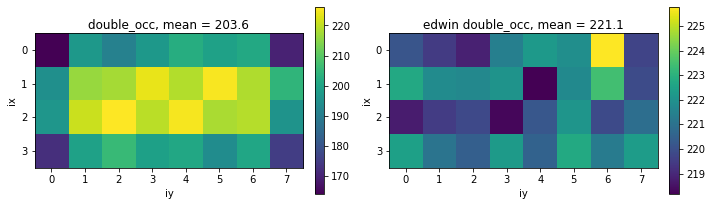

edwin gt0 dtype:float64, shape:(5, 10, 32, 32)


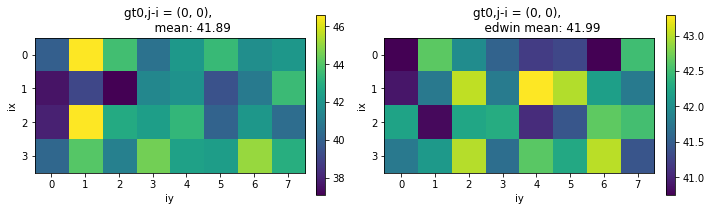

In [37]:
data_path = "../../Data-DQMC/test_accum/"
data_analysis.compare(params,eqlt_data,uneqlt_data,data_path);

In [38]:
data_analysis.summary(params,eqlt_data,uneqlt_data)

-------------------params-------------------
Nx = 4, dtype= <class 'int'>
Ny = 8, dtype= <class 'int'>
N = 32, dtype= <class 'int'>
U = 4, dtype= <class 'int'>
t = 1, dtype= <class 'int'>
tp = 0, dtype= <class 'int'>
mu = 0, dtype= <class 'int'>
beta = 1, dtype= <class 'int'>
L = 10, dtype= <class 'numpy.int64'>
dt = 0.1, dtype= <class 'numpy.float64'>
lmbd = 0.653732997987334, dtype= <class 'numpy.float64'>
bps = 2, dtype= <class 'int'>
n_sweep_warm = 200, dtype= <class 'int'>
n_sweep_meas = 800, dtype= <class 'int'>
period_eqlt = 5, dtype= <class 'int'>
period_uneqlt = 8, dtype= <class 'int'>
wrap_every = 8, dtype= <class 'int'>
batch_size = 16, dtype= <class 'int'>
-----------equal time measurements----------
n_sample=[1600], shape = (1,), dtype= int64
sign=[1600.], shape = (1,), dtype= float64
density shape = (4, 8), dtype= float64
double_occ shape = (4, 8), dtype= float64
zz shape = (32, 32), dtype= float64
xx shape = (32, 32), dtype= float64
nn shape = (32, 32), dtype= float64
pa

In [ ]:
scipy